# Using computed solutions to accelerate run time of GMRES

### Underlying idea

The underlying idea here is to use neural networks to interpolate converged solutions to provide initial guesses that are good guesses and lead to a speed up of GMRES. 

To be precise we consider problems of the form:
$$\mathbf{A}x=b$$
where $\mathbf{A} \in \mathbb{R}^{n\times n}$ and $x,b \in \mathbb{R}^n$

As with all iterative methods, we will start iterating with some iniital guess $x_o$. Depending on the properties of this guess, we can converge to a solution in fewer GMRES iterations. 



The underlying idea here is that we can train a Neural Network $N$ on a set of examples $\{x_i,b_i\}_{i=0}^m$ such that when provided a particular RHS $b'$ for our linear problem, we get an informed initial guess $x_o=N(b')$. 

In the parlance of machine learning, $\{x_i,b_i\}_{i=0}^m$ is our training set and the data corresponding to $m+1$th linear problem is our test set. We use $X_0=N(b_m)$ to solve  the $m+1$th linear problem. Then, we add the current test problem to our training set so that training set it is now augemented as $\{x_i,b_i\}_{i=0}^{m+1}$. $N$ is then retrained on this slightly differeent training set. 

### Summary and comments on an initial implementation

While in principle this idea is simple, early prototyping revealed some features that should be noted before some results for more refined iterations of this idea  are discussed. 

The initial implementation of this idea consisted of using a simple fully conencted network with one hidden layer of dimension $n$  with a ReLU activation function. As implied above, we note that the input dimension of the network is $n$ and the output dimension is $n$. 

- It was generally found that increasing the number of hidden layers did not contribute to the effectiveness of the method.


- As the amount of data being collected grows, training time can dramatically grow but not necessarily the usefullness of the initial guesses provided by the network. 


- The above point hints at the possibility that in this online context, the quality of data can be much more important  than  usual since we value train time as highly as accuracy 


- As the dimensions of the simple problems were increased, this approach scaled poorly since fully connected networks are not parallelized as implemented in pytorch. Dimensions greater 100 became prohibitive to train once moderate data was accumulated


- It can take alot of data and "visted solutions" before initial guesses start to produce helpful initial solutions. On a small workstation, this amount can be prohibitive


### List of ideas used to address  limitations

- To be able to test ideas on a small workstation computer, the type of network was switched to a small CNN early on. This architecture scales much better and allowed experiments in the 100's of dimensions to be possible. As observed with fully conencted networks, making the CNN deep yielded little gains with an often substantial increase of training time. Ultimately, it seems since we are thinking of an online context, what matters the most is having a "lightweight" model that can be retrained/updated quickly to some acceptable not too low tolerance. This is to be contrasted with the usual need of needing a highly accurate model and not caring too much about train time. 


- The "value" of training data can be maintained in order to reduce training time. One particular approach used here is to train the model often, and reject adding data that has already been fit well.  Then, from the batch of data that had made the cut, further filtering that data down with some metric. This general practice that has shown some measure of sucess can essentially be explained as trying to optimize the "value" of each data  point in our test set. ltering data also seems to improve the conditioning of the underlying optimazation problem, which further speeds up train time.


-  In addition to trying to minimize solution of initial guesses using the data, other quantities can be optimized based on certain needs

### A Demonstrative Example

To illustrate the ideas discussed a simple  particular problem will be examined. We will be solving a series of linear problems using restarted GMRES and then using that data to train a CNN as we solve the series of linear problems. Here we will compare the neural network assisted GMRES and GMRES directly. 


Here, $A$ will be the 1D scalar discrete laplacian, and $b$ will be defined as a "moving localized source".

Explicitly, $b$ is a vector of values given by :

$$b=\frac{1}{\sigma\sqrt{2\pi }}\exp\left({-\frac{1}{2}\left(\frac{z-y_j}{\sigma}\right)^2}\right)$$
where $z$ is a grid of $[-5,5]$ and $y_j$ is given by:

$$y_j=4\sin\left(\frac{1}{2}j|\cos{\frac{1}{2}j}|\right), \quad, j=0,1,2,3,\dots$$

The series of problems will be strucured in the following way:

1. Set index $j$ through for loop

2. Compute $b_j$

3. Call GMRES function assisted with neural network (MLGMRES) and collect diagnostic data. MLGMRES runs once up to some tolerance $e_1$
4. The previous result is then refined by a second GMRES call  until tolerance $e2$ is reached. Depending on diagnostic data, this refined solution may be added to the training data set and the model may be retrained. Note $e_1<e_2$

5. Call GMRES  directly and collect diagnostic data. Two calls are made. The first call converges up to tolerance $e_1$, and the second call then refines the solution to tolerance $e_2$. Then go to 1 

#### Some implementation updates

 - Minor changes have been made to pytorch API code. It has been written in such a way that the code should (hopefully) be device agnostic. Note that no memory optimizations of any sort have been preformed.  
 
 - The retrain method now either completes a large number of steps or stops once given tolerance is reached. Code:
 
   @timer
    def retrain_timed(self):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.loss_val = list()  # clear loss val history
        self.loss_val.append(10.0)
        t=0
        e1=1e-3
        while self.loss_val[-1]> e1 and t<self.n_steps:
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = self.model(self.x.to(device))

            # Compute and print loss
            loss = self.criterion(y_pred, self.y.to(device))
            self.loss_val.append(loss.item())

            # Zero gradients, perform a backward pass, and update the weights.
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            print('loss:',loss.item(),t)
            t=t+1

        print('Final loss:',loss.item(),t)
        # numparams=sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        # print('parameters',numparams)
        self.is_trained = True

- The optimizer has been changed to Adam algorithm. It simply performs better for our problem, but the details of methods and convergence ( as well as better online methods) will be touched on later. With this, we can get away with a larger learning rate. Code:

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)


- The network has been set up so that we minimize the number of parameters (while still having enough), while trying to try to maximally parallelize this naive implementation. Pytorch parallelizes along the channel dimension, so the network uses a massive kernel (size $n$, so out puts are of  length 1) and many channels ($n$ of them). This implementation doesn't use an output linear layer which would use alot of resources. We simply reshape the linear 1d conv. output of length 1 and $n$ channel dimensions as an array of dimension $n$.   Code:


constructor lines:

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.Conv1   = torch.nn.Conv1d(1,int(H),D_in, stride=1, padding=0, dilation=1, groups=1, bias=False, padding_mode='zeros').to(device)
        
        self.Conv2   = torch.nn.Conv1d(int(H),D_in,1, stride=1, padding=0, dilation=1, groups=1, bias=False, padding_mode='zeros').to(device)
        
        self.relu   = torch.nn.LeakyReLU().to(device)
        
        
forward function:
        Current_batchsize=int(x.shape[0])  # N in pytorch docs
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        x2=x.unsqueeze(1)  # Add channel dimension (C) to input 
        
        ConvOut1=self.relu(self.Conv1(x2.to(device)))
        
        ConvOut2=self.Conv2(ConvOut1) 
        
        y_pred = ConvOut2.view(Current_batchsize, -1) 

- As mentioned, without more serious computing power than a  laptop ( at least more than an Intel i7 6 core laptop with a modest Nvidia GPU), the training times quickly become unreasonable and we cannot proceede with testing these ideas on larger dimensions. While in practice we can expect much more computing  power, we can also expect massively more complex data. Thus, exploring some strategies to overcome these issues may be profitable for things to come. The solutions mentioned earlier ultimately come down to filtering data, and retraining the model often. The following ideas seemed to work best, but they often depend on the problem at hand. Ultimately, the good news here is that a flexible strategy can probably be found 


    - Use a high retrain frequency. This way, the model is already quite trained on the data set ( since the data set is only slightly altered) and can be trained quickly with a high learning rate. 
    
    
    - Only add data to the training set that is poorly fit by the model. For example, in the implementation used here, a moving average of the error of the neural network outputs is kept. If it does poorly in a particular case, data is added. If it does well, we do not add the data. Then, as the overall network outputs are improved, the moving average declines. 
    
    - Within the data that has made the cutoff and is in the  new batch that will be used to augment the training set, check that the data is sufficiently "different". For the case in the example presented here, since our solutions are rapidly spanning a space (due to considerably different RHS $n$ provided at different iterations), checking orthogonality is useful. However, if solutions are only changing slighly, an idea may be to check that their 1-norm difference is large enough. Eitherway, a context dependent approach to checking the "spread" of the batch that will augment the training set is quite useful for not prematurely bloating the training set( where such bloating is a concern) 
    
    - Another filter that I have had success with is to only add data when the solver time took longer than the running average. 
    
The underlying idea here is to carefully use our solution space as a basis to reduce error gradually and speedup calculations gradually rather than brute force accumulation of data and waiting for the big pay off later in the simulation. Next, these ideas are demonstrated. It is important to keep in mind that without these refinements, problems of $n>100$ could not reasonably run on (kevin's) hardware and would take hours to train (eventhough the problem itself takes 5 minures to run). 

#### Implemtation Example (logging stuff removed for brevity) 

$n=150$ example 

MLGMRES is set to optimize error as described above (10th iteration of GMRES) and run time as described above. So, solution data is added only when a particular run does poorer than the running average of these metrics. 

500 $b_i$ considered. 

In [1]:
from src_dir import *
import numpy as np
import matplotlib.pyplot as pp

In [17]:

dim=150
x0=np.squeeze(np.zeros((dim,1))) #1d array of zeros

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat  #1D scalar laplacian

retrain_freq=1 # Actually 3 behind the scenes
e1 = 1e-6 # first tolerance
e2 = 1e-10 # refinement tolerance
nmax_iter = 50  
restart   = 64

sigma=0.02  # spread of local source
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)  #Domain


n_steps =500   # number of problem iterations
InputDim=dim   # dimensions of input layer
HiddenDim=dim   # number of output channels in first conv
HiddenDim2=dim  # Kernel size for first layer and input channel dimension for second conv. layer. 
OutputDim=dim # dimensions of output layer (output of 1D Conv. Channel dimension before being falttened)

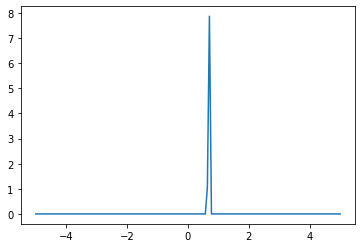

In [22]:
loc=4*np.sin(0.5*6*np.abs(np.cos(0.5*6)))
b=Gauss_pdf(x,loc,sigma)
pp.plot(x,b)

In [4]:

# Timed versions of both GMRES functions

@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [ ]:
# Primary experiment comparison loop

Err_list=[]
IterErrList10=[]
GmresRunTime=[]

NonML_Err_List=[]
NonML_Time_List=[]

debug=True

refine1=False
refine2=True

run_time=0.0
run_time_ML=0.0
trainTime_total=0.0
forwardTime_Total=0.0
run_time_ML_NoAdd=0.0

blist=[]
reslist=[]
x=np.linspace(DomainL,DomainR,dim)



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,Err_list,ProbIdx,restart,debug,refine1,blist,reslist,IterErrList10,GmresRunTime)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    Err_list=OutList1[1]
    IterErr0_AVG=OutList1[2]
    trainTime1=OutList1[3]
    forwardTime1=OutList1[4]
    blist=OutList1[5]
    reslist=OutList1[6]
    IterErrList10=OutList1[7]
    GmresRunTime=OutList1[8]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,Err_list,ProbIdx,restart,debug,refine2,blist,reslist,IterErrList10,GmresRunTime)
    Out2=OutList2[0]
    Err_list=OutList2[1]
    IterErr0_AVG=OutList2[2]
    trainTime2=OutList2[3]
    forwardTime2=OutList2[4]
    blist=OutList2[5]
    reslist=OutList2[6]
    IterErrList10=OutList2[7]
    GmresRunTime=OutList2[8]

    forwardTime_Total=forwardTime1+forwardTime2+forwardTime_Total
    trainTime_total=trainTime2+trainTime1+trainTime_total
    run_time_ML=run_time1_ML+run_time2_ML+run_time_ML




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    NonML_Time_List.append(run_time1)
    
    
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time=run_time1+run_time2+run_time
    
    print(ProbIdx)


print("Runtime of Non-decorated version is:",run_time)

print("Runtime of MLGMRES decorator is:",run_time_ML)

print("Runtime of training (backprop) is:",trainTime_total)

print("Runtime of forward function is:",forwardTime_Total)

The run times break down as follows:

Runtime of Non-decorated version is: 562.666750450182

Runtime of MLGMRES decorator is: 668.1811406349298

Runtime of training (backprop) is: 180.1929962550348

Runtime of forward function is: 0.4249187152599916

We see that in addition to keeping train times modest, this approach allows us to be able to see that the data is in fact speeding up the GMRES iterations. 


We can see this through the following plots. The lines in the two plots are the moving averages of the errors 

Text(0.5, 1.0, '$||r_{10}||$ per iteration for GMRES')

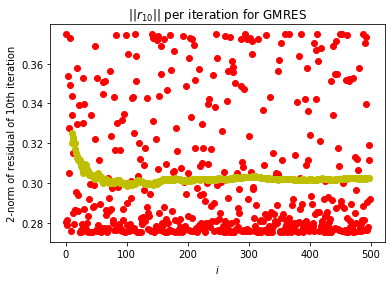

In [29]:
AVG=np.zeros((500,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,500)
for j in range(0,499):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

pp.plot(count,np.asarray(NonML_Err_List),'or',count[10:-1],AVG[10:-1],'oy')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$||r_{10}||$ per iteration for GMRES')

Text(0.5, 1.0, '$||r_{10}||$ per iteration for MLGMRES')

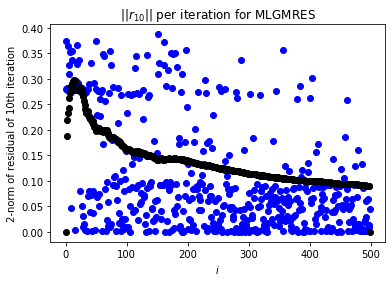

In [31]:
Err_Array_ML=np.asarray(IterErrList10)
AVGML=np.zeros((500,1))

for j in range(0,499):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)
pp.plot(count,np.asarray(Err_Array_ML),'ob',count,AVGML,'ok')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$||r_{10}||$ per iteration for MLGMRES')

Superimposing the two plots, we can appreaciate differences better. We have:

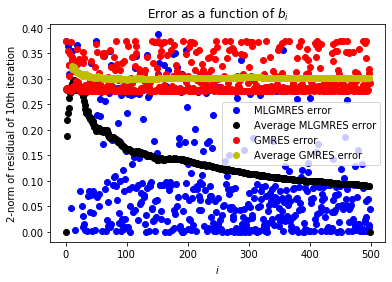

In [32]:
pp.plot(count,np.asarray(Err_Array_ML),'ob',label='MLGMRES error')
pp.plot(count,AVGML,'ok',label='Average MLGMRES error')
pp.plot(count,np.asarray(NonML_Err_List),'or',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'oy',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ ')
pp.legend(loc='best')
pp.savefig('Compare_150.png')

We see that the error is indeed declining as "time" moves forward. Next we look at a larger dimension problem more closely. 

$n=250$ example 

MLGMRES is set to optimize error as described above (10th iteration of GMRES) and run time as described above. So, solution data is added only when a particular run does poorer than the running average of these metrics. 

500 $b_i$ considered. 

In [24]:
dim=250
x0=np.squeeze(np.zeros((dim,1))) #1d array of zeros

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat  #1D scalar laplacian

retrain_freq=1 # Actually 3 behind the scenes
e1 = 1e-3 # first tolerance
e2 = 1e-10 # refinement tolerance
nmax_iter = 50  
restart   = 64

sigma=0.02  # spread of local source
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)  #Domain


n_steps =500   # number of problem iterations
InputDim=dim   # dimensions of input layer
HiddenDim=dim   # number of output channels in first conv
HiddenDim2=dim  # Kernel size for first layer and input channel dimension for second conv. layer. 
OutputDim=dim # dimensions of output layer (output of 1D Conv. Channel dimension before being falttened)

In [ ]:
# Primary experiment comparison loop

Err_list=[]
IterErrList10=[]
GmresRunTime=[]

NonML_Err_List=[]
NonML_Time_List=[]

debug=True

refine1=False
refine2=True

run_time=0.0
run_time_ML=0.0
trainTime_total=0.0
forwardTime_Total=0.0
run_time_ML_NoAdd=0.0

blist=[]
reslist=[]
x=np.linspace(DomainL,DomainR,dim)



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,Err_list,ProbIdx,restart,debug,refine1,blist,reslist,IterErrList10,GmresRunTime)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    Err_list=OutList1[1]
    IterErr0_AVG=OutList1[2]
    trainTime1=OutList1[3]
    forwardTime1=OutList1[4]
    blist=OutList1[5]
    reslist=OutList1[6]
    IterErrList10=OutList1[7]
    GmresRunTime=OutList1[8]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,Err_list,ProbIdx,restart,debug,refine2,blist,reslist,IterErrList10,GmresRunTime)
    Out2=OutList2[0]
    Err_list=OutList2[1]
    IterErr0_AVG=OutList2[2]
    trainTime2=OutList2[3]
    forwardTime2=OutList2[4]
    blist=OutList2[5]
    reslist=OutList2[6]
    IterErrList10=OutList2[7]
    GmresRunTime=OutList2[8]

    forwardTime_Total=forwardTime1+forwardTime2+forwardTime_Total
    trainTime_total=trainTime2+trainTime1+trainTime_total
    run_time_ML=run_time1_ML+run_time2_ML+run_time_ML




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    NonML_Time_List.append(run_time1)
    
    
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time=run_time1+run_time2+run_time
    
    print(ProbIdx)


print("Runtime of Non-decorated version is:",run_time)

print("Runtime of MLGMRES decorator is:",run_time_ML)

print("Runtime of training (backprop) is:",trainTime_total)

print("Runtime of forward function is:",forwardTime_Total)

The times for this run were:

Runtime of Non-decorated version is: 1083.3275152043498

Runtime of MLGMRES decorator is: 1142.929567166575

Runtime of training (backprop) is: 356.4194334131025

Runtime of forward function is: 0.3794740859011654




The main take away here is that the improvement in speed occured more quickly. Consequently, the overall runtime (even with training) of MLGMRES is similar to the usual GMRES run time.


Text(0.5, 1.0, '$||r_{10}||$ per iteration for GMRES')

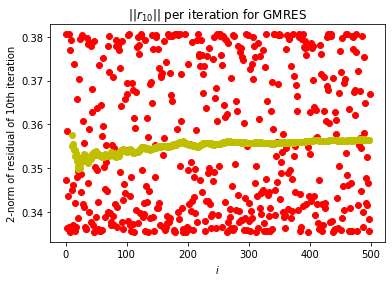

In [26]:
AVG=np.zeros((500,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,500)
for j in range(0,499):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

pp.plot(count,np.asarray(NonML_Err_List),'or',count[10:-1],AVG[10:-1],'oy')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$||r_{10}||$ per iteration for GMRES')

Text(0.5, 1.0, '$||r_{10}||$ per iteration for MLGMRES')

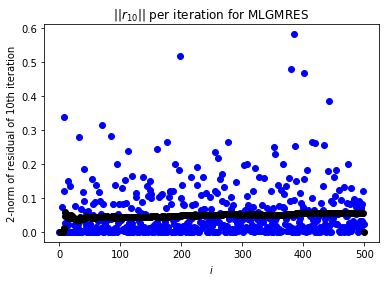

In [27]:
Err_Array_ML=np.asarray(IterErrList10)
AVGML=np.zeros((500,1))

for j in range(0,499):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)
pp.plot(count,np.asarray(Err_Array_ML),'ob',count,AVGML,'ok')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$||r_{10}||$ per iteration for MLGMRES')

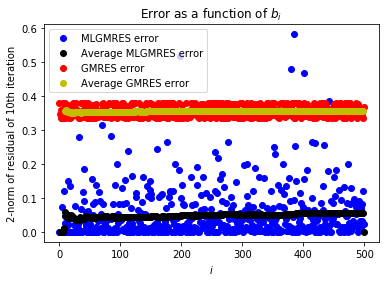

In [28]:
pp.plot(count,np.asarray(Err_Array_ML),'ob',label='MLGMRES error')
pp.plot(count,AVGML,'ok',label='Average MLGMRES error')
pp.plot(count,np.asarray(NonML_Err_List),'or',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'oy',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ ')
pp.legend(loc='best')
pp.savefig('Compare_250.png')

We can compare run times:

Text(0.5, 1.0, 'GMRES Run Times.')

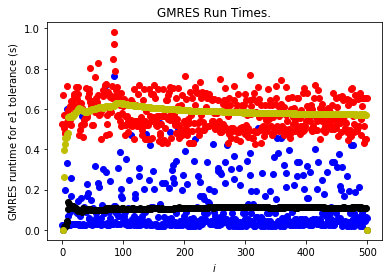

In [37]:
GmresRunTime_Array=np.asarray(Err_list)
AVG_GmresRunTime=np.zeros((500,1))

for j in range(0,499):
    AVG_GmresRunTime[j]=moving_average(np.asarray(Err_list[:j]),j)
pp.plot(count,np.asarray(Err_list),'ob',count,AVG_GmresRunTime,'ok')

NonMLGmresRunTime_Array=np.asarray(NonML_Time_List)
AVG_NonMLGmresRunTime=np.zeros((500,1))

for j in range(0,499):
    AVG_NonMLGmresRunTime[j]=moving_average(np.asarray(NonML_Time_List[:j]),j)
pp.plot(count,np.asarray(NonML_Time_List),'or',count,AVG_NonMLGmresRunTime,'oy')

pp.xlabel('$i$')
pp.ylabel('GMRES runtime for $e1$ tolerance (s)')
pp.title('GMRES Run Times.')